## Imports


In [1]:
import requests
from bs4 import BeautifulSoup
import urllib.request
from urllib.parse import quote
import re
import zipfile
import csv
from urllib.parse import quote
from requests.exceptions import RequestException
import os
import warnings
from requests.packages.urllib3.exceptions import InsecureRequestWarning
import ast
import csv
import requests
from requests.exceptions import RequestException
from bs4 import BeautifulSoup
from urllib.parse import quote
import zipfile
import re
import shutil
import itertools
import ast
import networkx as nx
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import community as community_louvain

%load_ext jupyternotify
# Ignore InsecureRequestWarning
warnings.filterwarnings("ignore", category=InsecureRequestWarning)

<IPython.core.display.Javascript object>

## File creation


Get one recipe


In [5]:
title = "Ferges\u00eb_e_Tiran\u00ebs_me_piperka_(Tirana_fergese_with_peppers)"
title = title.replace("/", "_").replace(":", "_").replace(" ", "_")
title = "".join(quote(c) if not c.isascii() else c for c in title)
print(title)

baseurl = "https://en.cookipedia.co.uk/wiki/api.php?"
action = "action=query"
query_title = "titles=" + title
content = "prop=revisions&rvprop=content"
dataformat = "format=json"

# Combine parameters in the correct order
query = "{}{}&{}&{}&{}".format(baseurl, action, query_title, content, dataformat)
print(query)
wikiresponse = requests.get(query, verify=False)
wikitext = wikiresponse.text

Ferges%C3%AB_e_Tiran%C3%ABs_me_piperka_(Tirana_fergese_with_peppers)
https://en.cookipedia.co.uk/wiki/api.php?action=query&titles=Ferges%C3%AB_e_Tiran%C3%ABs_me_piperka_(Tirana_fergese_with_peppers)&prop=revisions&rvprop=content&format=json


get the list of countries


In [6]:
baseurl = "https://www.cookipedia.co.uk/wiki/api.php?"
action = "action=query"
title = "titles=" + quote(
    "Template:CategoryRecipesCountry"
)  # URL encode the title and add 'titles='
content = "prop=revisions&rvprop=content"
dataformat = "format=json"

# Combine parameters in the correct order
query = "{}&{}&{}&{}".format(baseurl, action, title, content, dataformat)
print(query)
wikiresponse = requests.get(query, verify=False)
wikitext = wikiresponse.text

pattern = r"\[\[:Category:([^|\]]+)\|"

# Find all matches
countries = re.findall(pattern, wikitext)

# Print the matches
for country in countries:
    print(country)
print(len(countries))

https://www.cookipedia.co.uk/wiki/api.php?&action=query&titles=Template%3ACategoryRecipesCountry&prop=revisions&rvprop=content
Albanian_recipes
Algerian_recipes
Armenian_recipes
Austrian_recipes
Australian_recipes
Belgian_recipes
British_recipes
Bulgarian_recipes
Chilean_recipes
Chinese_recipes
Cuban_recipes
Czech recipes
Danish recipes
Dutch recipes
Ecuadorian recipes
Finnish recipes
French_recipes
German_recipes
Greek recipes
Hungarian_recipes
Indian recipes
Indonesian recipes
Irish recipes
Italian recipes
Jamaican recipes
Korean recipes
Latin American recipes
Lebanese recipes
Libyan recipes
Luxembourg_recipes
Mauritian recipes
Mexican recipes
Middle Eastern recipes
Moroccan recipes
North African recipes
North American recipes
Norwegian recipes
Oriental cuisine
Paraguayan recipes
Peruvian_recipes
Polish_recipes
Portuguese recipes
Romanian recipes
Russian recipes
Serbian recipes
Spanish recipes
Swedish recipes
Swiss recipes
Syrian recipes
Tex-Mex recipes
Thai recipes
Tunisian recipes


### Get recipe titles for each country


In [7]:
with open("recipe_titles.csv", "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Country", "Recipe Title"])  # Write the header

    # Loop through each country
    for country in countries:
        baseurl = "https://www.cookipedia.co.uk/wiki/api.php?"
        action = "action=query"
        list = "list=categorymembers"  # Get a list of pages in the category
        cmtitle = "cmtitle=" + quote(
            "Category:" + country
        )  # URL encode the category name and add 'cmtitle='
        dataformat = "format=json"
        cmcontinue = ""

        while True:
            # Combine parameters in the correct order, including cmcontinue for pagination
            query = "{}&{}&{}&{}".format(baseurl, action, list, cmtitle, dataformat)
            if cmcontinue:
                query += "&cmcontinue=" + cmcontinue

            wikiresponse = requests.get(query, verify=False)
            wikitext = wikiresponse.text

            # Parse the response as text to get the recipe titles
            recipe_titles = re.findall(r'"title": "(.+?)"', str(wikitext))

            for recipe_title in recipe_titles:
                recipe_title = (
                    recipe_title.replace("/", "_").replace(":", "_").replace(" ", "_")
                )
                print(recipe_title)
                writer.writerow([country, recipe_title])

            match = re.search(r'"cmcontinue": "(.*?)"', wikitext)
            if match:
                cmcontinue = match.group(1)
            else:
                break

Byrek_me_spinaq_(Spinach_pie)
Chilled_yoghurt_and_cucumber_soup_(tarator)
Chilled_yogurt
Comlek_(Rabbit_casserole_with_onions_and_wine_vinegar)
Ferges\u00eb_e_Tiran\u00ebs_me_piperka_(Tirana_fergese_with_peppers)
Fish_stew_from_Tirana
Garlic_and_walnut_sauce
Gjell\u00eb_me_arra_(Chicken_with_walnuts)
Jani_me_fasule_(Bean_soup)
Mehudehra_(Albanian_Garlic_soup)
Qofte_t\u00eb_f\u00ebrguara_(Fried_rissoles)
Tave_me_presh_(Baked_leeks)
Tirana_romaine_salad
Arnab_bil_tomatich_(Rabbit_with_tomato)
Brouklou_bil_dersa_(Cauliflower_in_dersa_sauce)
Bulghur_wheat_salad
Carrot_salad_with_grapefruit_and_orange_flower_water
Chalda_loubia_khadra_(Green_beans_with_almonds)
Chermoula
Chickpea_salad_with_red_onions_goats_cheese_and_paprika
Djedj_b'l-qasbour_(Stewed_chicken)
El_ham_lahou_(Ramadan_lamb)
Hut_bil_karfas_(Baked_fish_and_celery)
Kesksou_bil_djedj_(Couscous_with_chicken)
Kesksou_bil_djedj_-_couscous_with_chicken_(slow_cooker_recipe)
Lamb_meatballs
Osbane_es'smid_(Meat_soup_with_semolina_dumplin

### Create zip with recipes for each country


get all recipe texts in a zip, each file's name is the title (there are duplicates, because some recipes appeart in multiple countries)


In [8]:
def extract_ingredients(recipe_text):
    # Regex to get values between {{RecipeIngredients and ===Method=== parts
    pattern = r"RecipeIngredients(.*?)Method"
    match = re.search(pattern, recipe_text, re.DOTALL)
    if match:
        # Simplified regex to get the first word after [[
        ingredient_pattern = r"\[\[([^\]|]+)\|?[^\]]*\]\]"
        ingredients = re.findall(ingredient_pattern, match.group(1))
        return set(ingredients)
    else:
        return set()


txt = """
title\": "Ararat pilav (Rice with fruit)",
                "revisions": [
                    {
                        "contentformat": "text/x-wiki",
                        "contentmodel": "wikitext",
                        "*": "<!-- seo -->\n{{#seo:\n|title=Ararat pilav (Rice with fruit) a fruit recipe\n|titlemode=replace\n|keywords=#rice #butter #brandy #prunes #cinnamon #sultanas #stock #dried #apples #boiling #fry \n|hashtagrev=032020\n|description=A festive recipe from Armenia. You will need to soak the apricots and prunes overnight\n}}\n<!-- /seo -->\n\n{{Template:CookTools}}\n{{Template:AdvancePreparationIcon}}\n{{recipesummary\n|TotalCalories = 3232\n|PortionCalories = 808\n|DatePublished=27th October 2012\n|Author=Chef\n| ImageComment = Leaving Yerevan (''Armenia'') .. .. in an empty train\n |Servings = Serves 4\n |Difficulty = 2\n |TotalTime = 12 hours 40 minutes\n |PrepTime = 12 hours 10 minutes\n |CookTime = 30 minutes\n |Image = [[Image:Leaving Yerevan in an empty train.jpg|alt=Electus]]\n<span class=\"review\"> <span class=\"reviewHeader\">\n====Best recipe review====\n</span>\n''<span class=\"reviewTitle\">Overnight soak?</span>''\n\n<span style=\"line-height:180%\"><span style=\"font-size:180%;\"><span class=\"reviewScore\">3</span>/5</span>\n\n<span class=\"reviewDesc\">I always do, or it would be dry rice</span>\n\n<span class=\"reviewAuthor\"> [[User:PSmith|Paul&nbsp;R&nbsp;Smith]] </span></span>\n\n}}\nA festive recipe from Armenia.  You will need to soak the [[Apricots|apricots]] and [[Prunes|prunes]] overnight.\n\n'''For the [[Rice|rice]]'''\n{{RecipeIngredients\n| 50 g [[Butter|butter]]\n| 350 g [[Long grain rice|long grain rice]], washed under cold running water and drained\n| 1 teaspoon [[Salt|salt]]\n| 900 ml [[Boiling|boiling]] [[Stock|stock]] or water\n}}\n'''For the pilav'''\n{{RecipeIngredientsNB\n| 50 g [[Butter|butter]]\n| 75 g [[Blanched|blanched]] [[Almonds|almonds]]\n| 100 g [[Dried apricots|dried apricots]], soaked overnight, drained and coarsely chopped\n| 100 g stoned, [[Dried|dried]] [[Prunes|prunes]], soaked overnight, drained and coarsely chopped\n| 175 g [[Sultanas|sultanas]]\n| A pinch of [[Ground cloves|ground cloves]]\n| 25 g [[Sugar|sugar]]\n| &frac12; teaspoon [[Cinnamon|cinnamon]]\n| 2 [[Apples|apples]], cored, the inners lined with [[Tin foil|tin foil]]\n| 50 ml [[Brandy]]\n}}\n===Method===\n\n\n'''To cook the [[Rice|rice]]'''\n{{RecipeMethod\n| Melt the [[Butter|butter]] in a saucepan over a moderate heat.\n| Add the [[Rice|rice]] and [[Fry|fry]], stirring constantly for 2-3 minutes.\n| Add the [[Salt|salt]] and [[Boiling|boiling]] [[Stock|stock]] or water.\n| [[Boil]] vigorously for 2-3 minutes, reduce heat, cover and allow to [[Simmer|simmer]] for 15 minutes or until all the liquid has been absorbed.\n| Remove from heat and place a [[Tea towel|tea towel]] between the lid and the saucepan.\n| Allow to rest for 10-15 minutes, then fluff up the [[Rice|rice]] with a fork.\n}}\n'''To make the pilav'''\n{{RecipeMethod\n| Melt the [[Butter|butter]] in a saucepan, add the [[Nuts|nuts]], [[Dried|dried]] [[Fruits|fruits]], [[Cloves|cloves]] and [[Sugar|sugar]] and cook over a low heat, stirring often until the nuts are golden and the [[Sultanas|sultanas]] are plump.\n| Sprinkle with the [[Cinnamon|cinnamon]] and keep warm.\n| On a large serving platter, [[Pile|pile]] the [[Rice|rice]] into 2 separate peaks - a large one on the right and a smaller one on the left, to represent the shape of Mount Ararat.\n| Place the [[Apples|apples]] between the peaks and fill the lined cores with the [[Brandy|brandy]].\n| Arrange the [[Fruit|fruit]] and [[Nut|nut]] mixture around the peaks to reach about half way up the mountain, leaving the upper part to resemble snow.\n| Ignite the [[Brandy|brandy]] and serve.\n}}\n{{RecipeLine}}\n[[Category:Recipes]]\n[[Category:Armenian recipes]]\n[[Category:Rice recipes]]\n[[Category:Sweets and desserts]]\n[[Category:Vegetarian recipes]]\n[[Category:Fruit recipes]]\n[[Category:Steamed]]\n\n<!-- footer hashtags --><code 'hashtagrev:032020'>#rice #butter #brandy #prunes #cinnamon #sultanas #stock #dried #apples #boiling #fry </code><!-- /footer_hashtags -->"
                    }
                ]
            }
        }
    }
}
Retrieved from "https://www.cookipedia.co.uk/recipes_wiki/Special:ApiHelp"
"""
print(extract_ingredients(txt))

{'Apples', 'Long grain rice', 'Stock', 'Butter', 'Dried apricots', 'Cinnamon', 'Tin foil', 'Salt', 'Blanched', 'Boiling', 'Brandy', 'Sugar', 'Prunes', 'Ground cloves', 'Almonds', 'Dried', 'Sultanas'}


Create Aggregate_ingredients.txt and aggregate_recipes.txt


In [12]:
# Function to decode Unicode escape sequences in a string
def decode_unicode_escapes(text):
    return ast.literal_eval(f'"{text}"')


# Function to check if a string has non-ASCII characters
def has_non_ascii_chars(text):
    return any(ord(char) > 127 for char in text)


def normalize_filename(title):
    # Replace non-ASCII characters with an underscore
    normalized_title = re.sub(r"[^\x00-\x7F]", "_", title)
    return normalized_title

In [22]:
# CREATE AGGREGATED_INGREDIENTS/RECIPES.txt

aggregated_recipes_path = os.path.join("recipes", "aggregated_recipes.txt")

aggregated_ingredients_path = os.path.join("recipes", "aggregated_ingredients.txt")


def extract_ingredients(recipe_text):
    # Regex to get values between {{RecipeIngredients and ===Method=== parts

    pattern = r"RecipeIngredients(.*?)Method"

    match = re.search(pattern, recipe_text, re.DOTALL)

    if match:
        # Simplified regex to get the first word after [[

        ingredient_pattern = r"\[\[([^\]|]+)\|?[^\]]*\]\]"

        ingredients = re.findall(ingredient_pattern, match.group(1))

        return set(ingredients)

    else:
        return set()


with open("recipe_titles.csv", "r") as file:
    # Create a CSV reader

    reader = csv.reader(file)

    # Skip the header

    next(reader)

    # Create a new zip file

    with zipfile.ZipFile("recipes.zip", "w") as zipf:
        # Loop through each row in the CSV file

        for row in reader:
            country, title = row

            print(country, title)

            country_folder = os.path.join("recipes", country)

            os.makedirs(country_folder, exist_ok=True)

            # Create a folder for combined files inside the country folder

            combined_folder = os.path.join(country_folder, "combined")

            os.makedirs(combined_folder, exist_ok=True)

            # recipe_file_path = os.path.join(country_folder, f"{title}.txt")

            decoded_title = decode_unicode_escapes(title)
            if has_non_ascii_chars(decoded_title):
                print(
                    f"Skipping file creation for {decoded_title}: Contains non-ASCII characters"
                )
                continue  # Skip creating the file if it contains non-ASCII characters

            normalized_title = normalize_filename(decoded_title)
            recipe_file_path = os.path.join(country_folder, f"{normalized_title}.txt")

            baseurl = "https://en.cookipedia.co.uk/wiki/api.php?"

            action = "action=query"

            query_title = "titles=" + title

            content = "prop=revisions&rvprop=content"

            dataformat = "format=json"

            # Combine parameters in the correct order

            query = "{}&{}&{}&{}".format(
                baseurl, action, query_title, content, dataformat
            )

            try:
                wikiresponse = requests.get(query, verify=False)

                wikiresponse.raise_for_status()

                # Extract text content using BeautifulSoup

                soup = BeautifulSoup(wikiresponse.text, "html.parser")

                text_content = soup.get_text()

                start_index = text_content.find("title")

                text_content = text_content[start_index:] if start_index != -1 else ""

                # Write the text to a file in the country folder

                with open(recipe_file_path, "w", encoding="utf-8") as recipe_file:
                    recipe_file.write(text_content)

                # Write the text to a file in the zip file

                zipf.writestr(os.path.join(country, f"{title}.txt"), text_content)

            except RequestException as e:
                print(f"Error in request: {e}")

Albanian_recipes Byrek_me_spinaq_(Spinach_pie)
Albanian_recipes Chilled_yoghurt_and_cucumber_soup_(tarator)
Albanian_recipes Chilled_yogurt
Albanian_recipes Comlek_(Rabbit_casserole_with_onions_and_wine_vinegar)
Albanian_recipes FergesÃ«_e_TiranÃ«s_me_piperka_(Tirana_fergese_with_peppers)
Skipping file creation for FergesÃ«_e_TiranÃ«s_me_piperka_(Tirana_fergese_with_peppers): Contains non-ASCII characters
Albanian_recipes Fish_stew_from_Tirana
Albanian_recipes Garlic_and_walnut_sauce
Albanian_recipes GjellÃ«_me_arra_(Chicken_with_walnuts)
Skipping file creation for GjellÃ«_me_arra_(Chicken_with_walnuts): Contains non-ASCII characters
Albanian_recipes Jani_me_fasule_(Bean_soup)
Albanian_recipes Mehudehra_(Albanian_Garlic_soup)
Albanian_recipes Qofte_tÃ«_fÃ«rguara_(Fried_rissoles)
Skipping file creation for Qofte_tÃ«_fÃ«rguara_(Fried_rissoles): Contains non-ASCII characters
Albanian_recipes Tave_me_presh_(Baked_leeks)
Albanian_recipes Tirana_romaine_salad
Algerian_recipes Arnab_bil_tomat

KeyboardInterrupt: 

In [23]:
# Create a set to hold the combined ingredients from all countries
combined_ingredients_set = set()

# Open the aggregated files in append mode
with open(
    "aggregated_recipes.txt", "a", encoding="utf-8"
) as aggregated_recipes_file, open(
    "aggregated_ingredients.txt", "a", encoding="utf-8"
) as aggregated_ingredients_file:
    # Process each country separately
    for country_folder in os.listdir("recipes"):
        if os.path.isdir(os.path.join("recipes", country_folder)):
            combined_folder = os.path.join("recipes", country_folder, "combined")
            os.makedirs(combined_folder, exist_ok=True)

            combined_recipe_file_path = os.path.join(
                combined_folder, f"{country_folder}_recipes.txt"
            )
            combined_ingredients_file_path = os.path.join(
                combined_folder, f"{country_folder}_ingredients.txt"
            )

            with open(
                combined_recipe_file_path, "w", encoding="utf-8"
            ) as combined_recipe_file, open(
                combined_ingredients_file_path, "w", encoding="utf-8"
            ) as combined_ingredients_file:
                ingredients_set = set()

                # Process each recipe file in the country folder
                for recipe_file in os.listdir(os.path.join("recipes", country_folder)):
                    if (
                        recipe_file.endswith(".txt")
                        and recipe_file != f"{country_folder}_ingredients.txt"
                        and recipe_file != f"{country_folder}_recipes.txt"
                    ):
                        with open(
                            os.path.join("recipes", country_folder, recipe_file),
                            "r",
                            encoding="utf-8",
                        ) as individual_recipe_file:
                            recipe_text = individual_recipe_file.read()
                            combined_recipe_file.write(recipe_text + "\n")
                            # Extract ingredients using regex
                            ingredients = extract_ingredients(recipe_text)
                            ingredients_set.update(ingredients)
                            # Add the ingredients to the combined ingredients set
                            combined_ingredients_set.update(ingredients)

                            # Write the recipe to the aggregated recipes file
                            aggregated_recipes_file.write(recipe_text + "\n")

                # Write the unique ingredients to the combined ingredients file
                for ingredient in ingredients_set:
                    combined_ingredients_file.write(ingredient + "\n")

# Write the unique ingredients to the aggregated ingredients file
with open(
    "aggregated_ingredients.txt", "w", encoding="utf-8"
) as aggregated_ingredients_file:
    for ingredient in combined_ingredients_set:
        aggregated_ingredients_file.write(ingredient + "\n")


# Move the aggregated files to the 'recipes' folder
shutil.move("aggregated_recipes.txt", "recipes/aggregated_recipes.txt")
shutil.move("aggregated_ingredients.txt", "recipes/aggregated_ingredients.txt")

'recipes/aggregated_ingredients.txt'

## Dataframe creation


### Creation folder recipes


In [39]:
import re
import os

recipes_path = r"C:\Users\Dell\OneDrive - Danmarks Tekniske Universitet\DTU\Social Graphs Fall 23\Project_A\recipes\aggregated_recipes.txt"
# Leggiamo il testo dal file aggregated_recipes.txt

with open(recipes_path, "r", encoding="utf-8") as file:
    text = file.read()
    # print(text)

# Dividiamo il testo in blocchi separati relativi a ogni ricetta
recipes = text.split("\n\n\n")
# print(recipes)
# Creiamo una cartella per salvare i file delle ricette
if not os.path.exists("Recipes Texts"):
    os.makedirs("Recipes Texts")

# Pattern regex per estrarre il titolo della ricetta
title_pattern = re.compile(r'title": "(.*?)"')

# Iteriamo attraverso i blocchi di testo relativi a ogni ricetta
for i, recipe_text in enumerate(recipes):
    # Cerchiamo il titolo della ricetta nel testo
    match = title_pattern.search(recipe_text)
    if match:
        # Estraiamo il titolo
        title = match.group(1)

        # Puliamo il titolo per utilizzarlo come nome del file
        clean_title = re.sub(r"[^\w\s]", "", title)

        # Creiamo il percorso completo del file
        file_name = f"{i + 1}_{clean_title}.txt"
        file_path = os.path.join("Recipes Texts", file_name)

        # Scriviamo il testo della ricetta nel file separato
        with open(file_path, "w", encoding="utf-8") as recipe_file:
            recipe_file.write(recipe_text)

Ricette separate create con successo!


### Creation dataframe recipes


In [63]:
title_pattern = r'title": "([^"]+)"'
total_calories_pattern = r"TotalCalories = (\d+)"
portion_calories_pattern = r"PortionCalories = (\d+)"
difficulty_pattern = r"Difficulty = (\d+)"
servings_pattern = r"Servings = ([^\n|]+)"
total_time_pattern = r"TotalTime = ([^\n|]+)(?=\n|\|\s*PrepTime|\|\s*CookTime|\n\}\})"
prep_time_pattern = r"PrepTime = ([^\n|]+)"
cook_time_pattern = r"CookTime = ([^\n|]+)"
ingredients_pattern = r"RecipeIngredients\n\|(.+?)(?=\n==="
ingredient_item_pattern = r"\[\[(.*?)\]\]"

columns = [
    "Recipe",
    "total_calories",
    "portion_calories",
    "difficulty",
    "servings",
    "total_time",
    "prep_time",
    "cook_time",
    "ingredients",
]
recipe_data = pd.DataFrame(columns=columns)

# Folder path with the recipes texts
folder_path = "Recipes Clean Texts"  # REKA's FOLDER

# For loop to analyze each file.txt
for filename in os.listdir(folder_path):
    filepath = os.path.join(folder_path, filename)

    with open(filepath, "r", encoding="utf-8") as file:
        recipe_text = file.read()

        # Extract data using regex
        title = (
            re.search(title_pattern, recipe_text).group(1)
            if re.search(title_pattern, recipe_text)
            else None
        )
        total_calories = (
            re.search(total_calories_pattern, recipe_text).group(1)
            if re.search(total_calories_pattern, recipe_text)
            else None
        )
        portion_calories = (
            re.search(portion_calories_pattern, recipe_text).group(1)
            if re.search(portion_calories_pattern, recipe_text)
            else None
        )
        difficulty = (
            re.search(difficulty_pattern, recipe_text).group(1)
            if re.search(difficulty_pattern, recipe_text)
            else None
        )
        servings = (
            re.search(servings_pattern, recipe_text).group(1)
            if re.search(servings_pattern, recipe_text)
            else None
        )
        total_time = (
            re.search(total_time_pattern, recipe_text).group(1)
            if re.search(total_time_pattern, recipe_text)
            else None
        )
        prep_time = (
            re.search(prep_time_pattern, recipe_text).group(1)
            if re.search(prep_time_pattern, recipe_text)
            else None
        )
        cook_time = (
            re.search(cook_time_pattern, recipe_text).group(1)
            if re.search(cook_time_pattern, recipe_text)
            else None
        )

        # Find the start and end indices of the ingredient section
        start_index = recipe_text.find("RecipeIngredients")
        end_index = recipe_text.find("===", start_index)

        # Extract the section containing ingredients
        ingredient_section = recipe_text[start_index:end_index]

        # Split the section to get individual lines and extract ingredients
        # Extract ingredients between double square brackets
        ingredients = re.findall(r"\[\[([^][]+?)\]\]", ingredient_section)
        cleaned_ingredients = [
            ingredient.split("|")[0] if "|" in ingredient else ingredient
            for ingredient in ingredients
        ]

        # Create a DataFrame with the extracted data
        new_data = {
            "Recipe": title,
            "total_calories": total_calories,
            "portion_calories": portion_calories,
            "difficulty": difficulty,
            "servings": servings,
            "total_time": total_time,
            "prep_time": prep_time,
            "cook_time": cook_time,
            "ingredients": cleaned_ingredients,
        }

        # Create new line of the actual df

        recipe_data.loc[len(recipe_data.index)] = new_data


recipe_data.head()

Recipe total_calories portion_calories  \
0            Barbecued beef - Chinese style           1171              292   
1  Beef Massaman curry (slow cooker recipe)           6047             1511   
2                 Black bean prawn stir fry           1836              459   
3                        Braised aubergines           1021              255   
4                    Cajun Chicken Stir Fry            467               23   

  difficulty     servings              total_time              prep_time  \
0          1   Serves 4\n    3 hours 20 minutes\n    3 hours 5 minutes\n   
1          2          4\n   8 hours, 15 minutes\n           15 minutes\n   
2          2  Serves 4\n            30 minutes\n           20 minutes\n    
3          1  Serves 4\n            15 minutes\n            5 minutes\n    
4          1   Serves 2\n   3 hours, 17 minutes\n   3 hours, 5 minutes\n   

       cook_time                                        ingredients  
0   15 minutes\n  [braising steak, dark soy sauce, Garlic, 5 spi...  
1      8 hours\n  [New Potatoes, Ghee, Vegetable oil, Massaman c...  
2  10 minutes\n   [king prawns, Garlic, Ginger, chillies, spring...  
3  10 minutes\n   [aubergines, ginger, Garlic, light soy sauce, ...  
4   12 minutes\n  [Chicken breast, lime juice, Taste Sensation C...

Save the dataframe in csv file


In [64]:
recipe_data.to_csv(
    "recipe_data.csv", index=False
)  # Set index=False to avoid saving row indices

To load it:


In [2]:
recipes_data = pd.read_csv("recipes_data.csv")

## Graph creation

### Main Ingredient Graph

In [4]:
def add_edge(graph, ingredient_list):
    ingredients_combinations = list(itertools.combinations(ingredient_list, 2))
    for combo in ingredients_combinations:
        if graph.has_edge(combo[0], combo[1]):
            graph[combo[0]][combo[1]]["weight"] += 1
        else:
            graph.add_edge(combo[0], combo[1], weight=1)


# Initialize an undirected graph
G = nx.Graph()

# Directory containing recipe files
recipes_dir = "recipes"


# Extract ingredients from txt
txt_path = r".\recipes\aggregated_ingredients.txt"

ingredients_list = open(txt_path).readlines()

ingredients_list = [ingredient.strip() for ingredient in ingredients_list]

# ADD NODES
G.add_nodes_from(ingredients_list)
G.nodes()

for ingredients_str in recipes_data["ingredients"]:
    ingredients_list = ast.literal_eval(ingredients_str)
    add_edge(G, ingredients_list)

G.edges()

EdgeView([('salt pork', 'Clams'), ('salt pork', 'Minced'), ('salt pork', 'Frozen'), ('salt pork', 'Flour'), ('salt pork', 'Potato'), ('salt pork', 'Dice'), ('salt pork', 'Onion'), ('salt pork', 'Boiling'), ('salt pork', 'Litres'), ('salt pork', 'Milk'), ('salt pork', 'Butter'), ('salt pork', 'Salt'), ('salt pork', 'Pepper'), ('Melon', 'Cucumber'), ('Melon', 'Lemongrass'), ('Melon', 'Grated'), ('Melon', 'Ginger'), ('Melon', 'Chilli'), ('Melon', 'Coconut milk'), ('Melon', 'Basil'), ('Melon', 'Mint'), ('Melon', 'Limes'), ('Melon', 'Juice'), ('Melon', 'Zest'), ('Melon', 'Olive oil'), ('Melon', 'Halloumi cheese'), ('Melon', 'Rocket'), ('Melon', 'Bitter'), ('Melon', 'Salad'), ('Melon', 'Basil leaves'), ('Melon', 'Mint leaves'), ('Melon', 'Lemon'), ('Melon', 'Balsamic vinegar'), ('Melon', 'Freshly ground black pepper'), ('Melon', 'cloves of garlic'), ('lobster bisque', 'Fresh pasta'), ('lobster bisque', 'dried taglitelle'), ('lobster bisque', 'peeled prawns'), ('lobster bisque', 'dried taglia

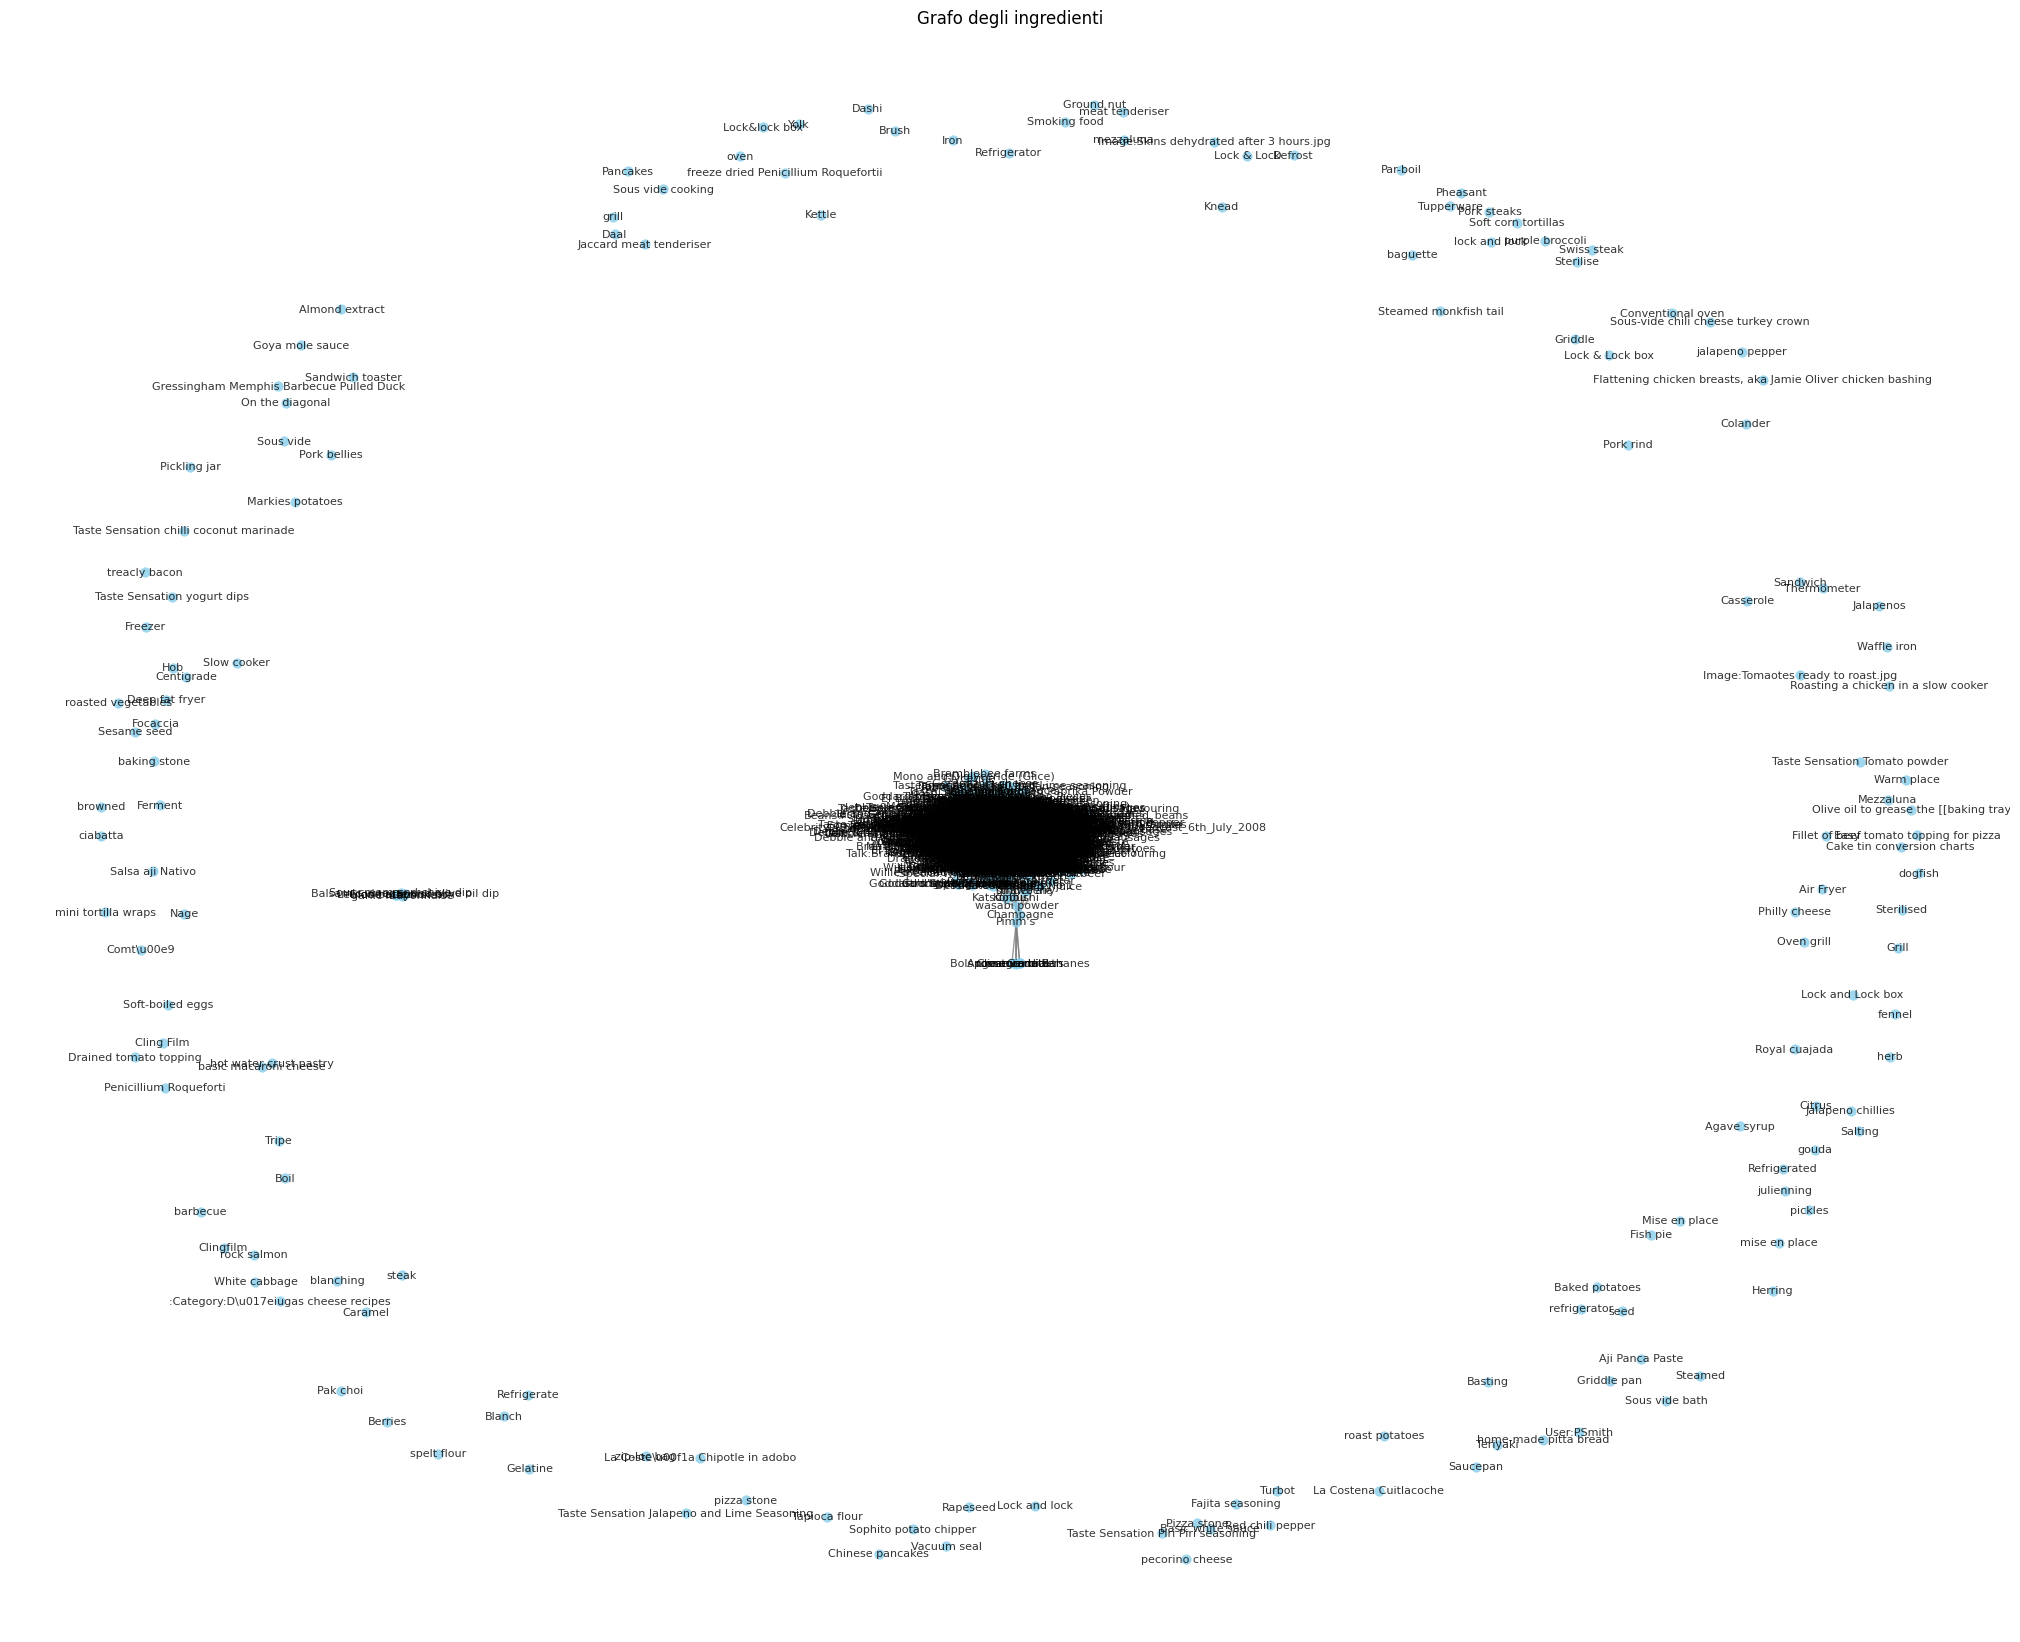

In [5]:
pos = nx.spring_layout(G)

plt.figure(figsize=(20, 16))
nx.draw(
    G,
    pos=pos,
    with_labels=True,
    node_size=50,
    font_size=8,
    alpha=0.8,
    node_color="skyblue",
    edge_color="grey",
    linewidths=0.2,
)
plt.title("Grafo degli ingredienti")
plt.axis("off")
plt.show()

In [36]:
# Save graph
with open("Graph_ingredients.pkl", "wb") as f:
    pickle.dump(G, f)

In [2]:
# LOAD THE GRAPH
with open("Graph_ingredients.pkl", "rb") as f:
    G_ingredients = pickle.load(f)

In [ ]:
nodes_to_remove = ["Dried", "Juice", "Zest"]

# Check if the nodes exist in the graph before removing
for node in nodes_to_remove:
    if node in G_ingredients.nodes():
        G_ingredients.remove_node(node)
    else:
        print(f"The node {node} doesn't exist in the graph.")

In [6]:
# sorted edges in descendent order
sorted_edges = sorted(
    G_ingredients.edges(data=True), key=lambda x: x[2]["weight"], reverse=True
)

# First 50 edges
top_50_edges = sorted_edges[:50]

print(top_50_edges)

[('Garlic', 'Olive oil', {'weight': 436}), ('Salt', 'Olive oil', {'weight': 374}), ('Sea Salt', 'Freshly ground black pepper', {'weight': 371}), ('Garlic', 'Salt', {'weight': 348}), ('Freshly ground black pepper', 'Olive oil', {'weight': 340}), ('Sea Salt', 'Olive oil', {'weight': 332}), ('Pepper', 'Salt', {'weight': 297}), ('Onion', 'Olive oil', {'weight': 291}), ('Garlic', 'Onion', {'weight': 286}), ('Salt', 'Onion', {'weight': 275}), ('Tomatoes', 'Olive oil', {'weight': 218}), ('Butter', 'Salt', {'weight': 215}), ('Sea Salt', 'Garlic', {'weight': 208}), ('Parsley', 'Olive oil', {'weight': 199}), ('Freshly ground black pepper', 'Onion', {'weight': 186}), ('Garlic', 'Tomatoes', {'weight': 180}), ('Garlic', 'Freshly ground black pepper', {'weight': 177}), ('Butter', 'Olive oil', {'weight': 165}), ('Salt', 'Tomatoes', {'weight': 164}), ('Salt', 'Onions', {'weight': 164}), ('Salt', 'Parsley', {'weight': 161}), ('Sea Salt', 'Onion', {'weight': 158}), ('Cloves', 'Garlic', {'weight': 156}),

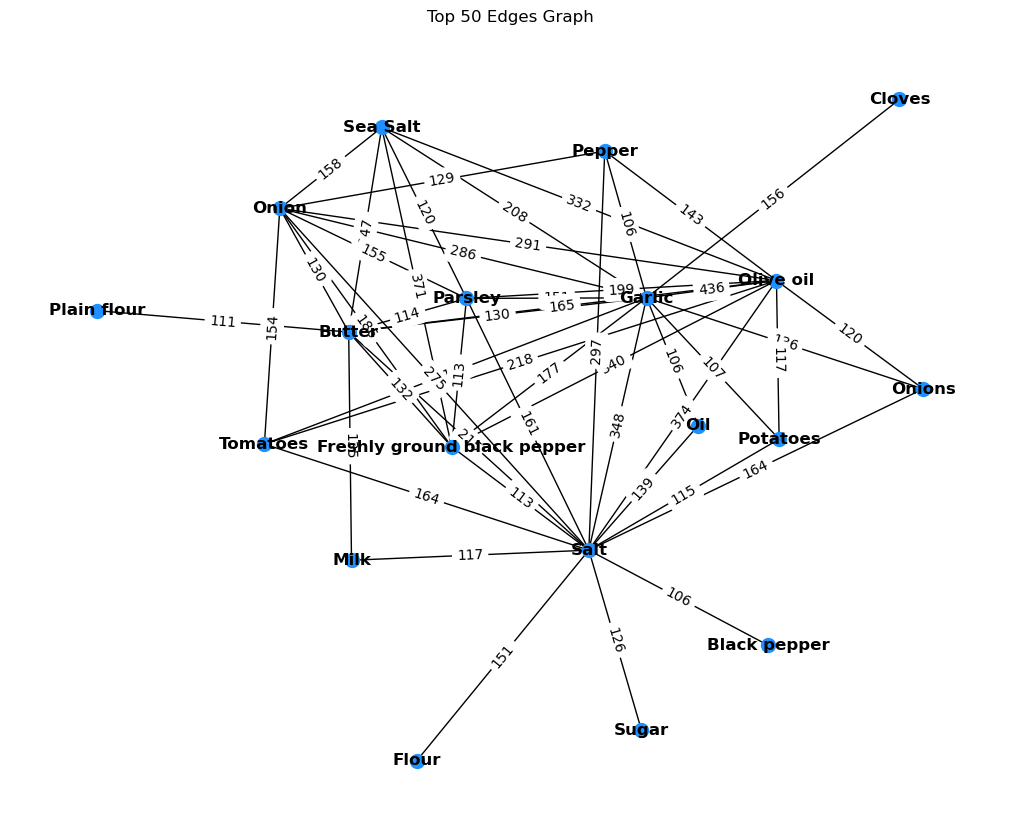

In [7]:
# Create an empty graph
G_top_50 = nx.Graph()

# Add edges from the top 50 edges list
for edge in top_50_edges:
    node1, node2, weight = edge
    G_top_50.add_edge(node1, node2, weight=weight["weight"])

plt.figure(figsize=(10, 8))  # Set the size of the figure

# Draw the graph
pos = nx.kamada_kawai_layout(G_top_50)

edge_labels = {(u, v): d["weight"] for u, v, d in G_top_50.edges(data=True)}
nx.draw(
    G_top_50,
    pos,
    with_labels=True,
    node_color="dodgerblue",
    node_size=100,
    font_weight="bold",
)
nx.draw_networkx_edge_labels(G_top_50, pos, edge_labels=edge_labels)

# Show the graph
plt.title("Top 50 Edges Graph")
plt.show()

### Largest component Graph

In [8]:
largest_component = max(nx.connected_components(G_ingredients), key=len)
G_ing_sub = G_ingredients.subgraph(largest_component)

In [58]:
pos = nx.kamada_kawai_layout(G_ing_sub)

plt.figure(figsize=(15, 8))
nx.draw(
    G_ing_sub,
    pos=pos,
    with_labels=True,
    node_size=50,
    font_size=8,
    alpha=0.8,
    node_color="skyblue",
    edge_color="grey",
    linewidths=0.2,
)
plt.title("Grafo degli ingredienti")
plt.axis("off")
plt.show()

In [23]:
number_of_nodes = len(G_ing_sub.nodes)
print("Number of nodes in the network:", number_of_nodes)

Number of nodes in the network: 2843


In [9]:
number_of_links = len(G_ing_sub.edges())
print("Number of links in the network:", number_of_links)

Number of links in the network: 79573


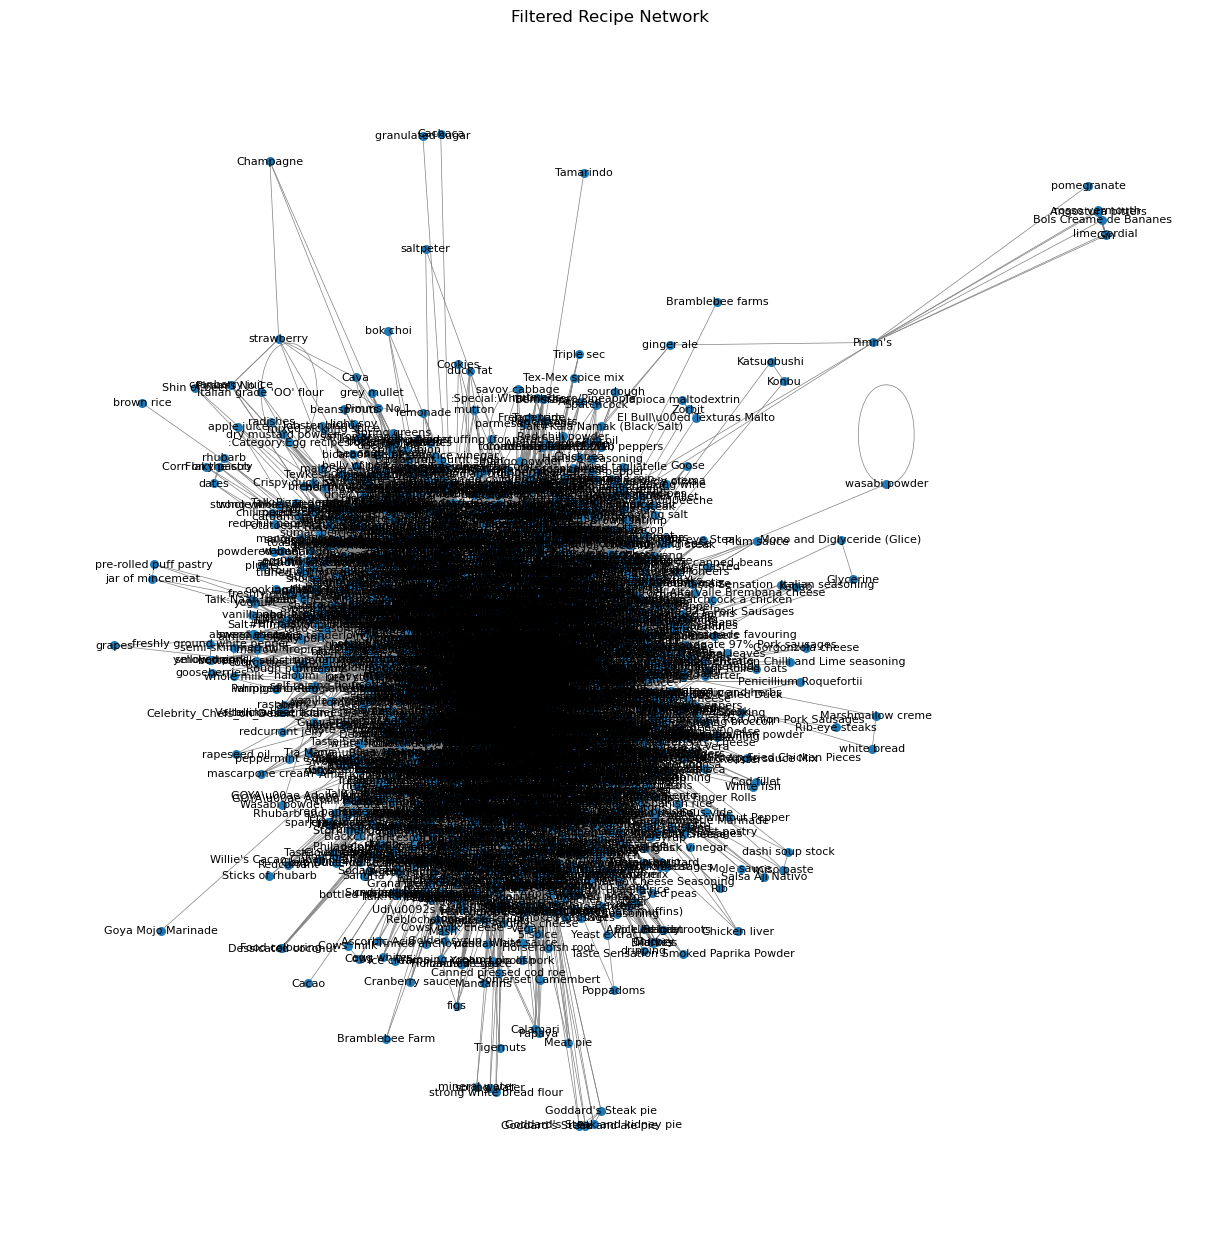

In [13]:
# Different layout and visualization adjustments
# pos = nx.kamada_kawai_layout(G_ing_sub)
pos = nx.spring_layout(G_ing_sub)

plt.figure(figsize=(12, 12))
nx.draw(
    G_ing_sub,
    pos,
    node_size=30,
    font_size=8,
    font_color="black",
    with_labels=True,
    width=0.5,
    edge_color="gray",
)
plt.title("Filtered Recipe Network")
plt.show()

### Creating Recipes Graph

In [16]:
# LOAD AND CONVERT INGREDIENTS IN LIST (Otehrwise they are read as a single string)
recipes_data = pd.read_csv("recipes_data_updated.csv")
recipes_data["ingredients"] = recipes_data["ingredients"].apply(lambda x: x.split(","))


# Rimuovi spazi in eccesso e caratteri '[' e ']' dagli ingredienti
def clean_ingredient(ingredient):
    if ingredient != "black pepper":
        return (
            ingredient.strip()
            .replace("[", "")
            .replace("]", "")
            .replace('"', "")
            .replace("'", "")
        )
    else:
        return ingredient


recipes_data["ingredients"] = recipes_data["ingredients"].apply(
    lambda x: [clean_ingredient(ingredient) for ingredient in x]
)

In [17]:
type_elem = type(recipes_data["ingredients"].iloc[0])

if type_elem is list:
    print("Ingredients are a list of strings")
else:
    print("Ingredients are a single string")

Ingredients are a list of strings


In [18]:
# Create a boolean mask to eliminate the empty rows (badly read)
mask = recipes_data.drop("Recipe", axis=1).apply(
    lambda row: all(pd.isnull(row)) or all(val == "" or val == "['']" for val in row),
    axis=1,
)

# delete rows with the mask condition
recipes_data = recipes_data[~mask]

In [19]:
# Delete duplicate rows
recipes_data = recipes_data.drop_duplicates(subset="Recipe")
# recipes_data.describe

In [23]:
%%notify
G_recipes = nx.Graph()

# Add nodes with attributes
for index, row in recipes_data.iterrows():
    recipe_name = row["Recipe"]
    recipe_attributes = {
        "Total_calories": row["total_calories"],
        "Portion_calories": row["portion_calories"],
        "Difficulty": row["difficulty"],
        "Servings": row["servings"],
        "Total_time": row["total_time"],
        "Prep_time": row["prep_time"],
        "Cook_time": row["cook_time"],
        "Ingredients": row["ingredients"],
    }
    G_recipes.add_node(recipe_name, **recipe_attributes)

# Nodes connection based on common ingredients
for recipe1, recipe2 in itertools.combinations(G_recipes.nodes(), 2):
    ingredients1 = set(
        recipes_data.loc[recipes_data["Recipe"] == recipe1, "ingredients"].iloc[0]
    )
    ingredients2 = set(
        recipes_data.loc[recipes_data["Recipe"] == recipe2, "ingredients"].iloc[0]
    )

    common_ingredients = ingredients1 & ingredients2

    if common_ingredients:
        # Weight assignment based on the number of common ingredients
        weight = len(common_ingredients)
        G_recipes.add_edge(recipe1, recipe2, weight=weight)

# Edges and nodes number
print(f"Number of nodes: {G_recipes.number_of_nodes()}")
print(f"Number of edges: {G_recipes.number_of_edges()}")

Number of nodes: 2429
Number of edges: 1138633


<IPython.core.display.Javascript object>

In [14]:
for edge in G_recipes.edges():
    node1, node2 = edge
    common_ingredients = set(G_recipes.nodes[node1]["Ingredients"]).intersection(
        set(G_recipes.nodes[node2]["Ingredients"])
    )
    print(
        f"Edge between '{node1}' and '{node2}' has common ingredients: {common_ingredients}"
    )

NameError: name 'G_recipes' is not defined

Adding Country as attribute of the node

In [31]:
# Directory containing folders with recipes divided by country
recipes_directory = "recipes"

# Traverse through all nodes in the graph
for node in G_recipes.nodes():
    # Name of the node (presumably corresponding to the recipe name)
    recipe_name = node

    # Check in all folders if the recipe is present
    for country_folder in os.listdir(recipes_directory):
        country_folder_path = os.path.join(recipes_directory, country_folder)

        # Check if it's a directory
        if os.path.isdir(country_folder_path):
            # Check if the recipe is present in the country folder
            if os.path.exists(os.path.join(country_folder_path, f"{recipe_name}.txt")):
                # Add the "Country" attribute to the node with the name of the country
                G_recipes.nodes[node]["Country"] = re.split(r"[_\s]+", country_folder)[
                    0
                ]
                # print(G_recipes.nodes[node]["Country"])
                break  # Exit the loop if a match is found

In [26]:
# Save graph
with open("Graph_recipes.pkl", "wb") as f:
    pickle.dump(G_recipes, f)

In [27]:
# LOAD THE GRAPH
with open("Graph_recipes.pkl", "rb") as f:
    G_recipes = pickle.load(f)

In [28]:
print(f"Number of nodes: {G_recipes.number_of_nodes()}")
print(f"Number of edges: {G_recipes.number_of_edges()}")

Number of nodes: 2429
Number of edges: 1138633


In [15]:
largest_component = max(nx.connected_components(G_recipes), key=len)
G_rec_sub = G_recipes.subgraph(largest_component)

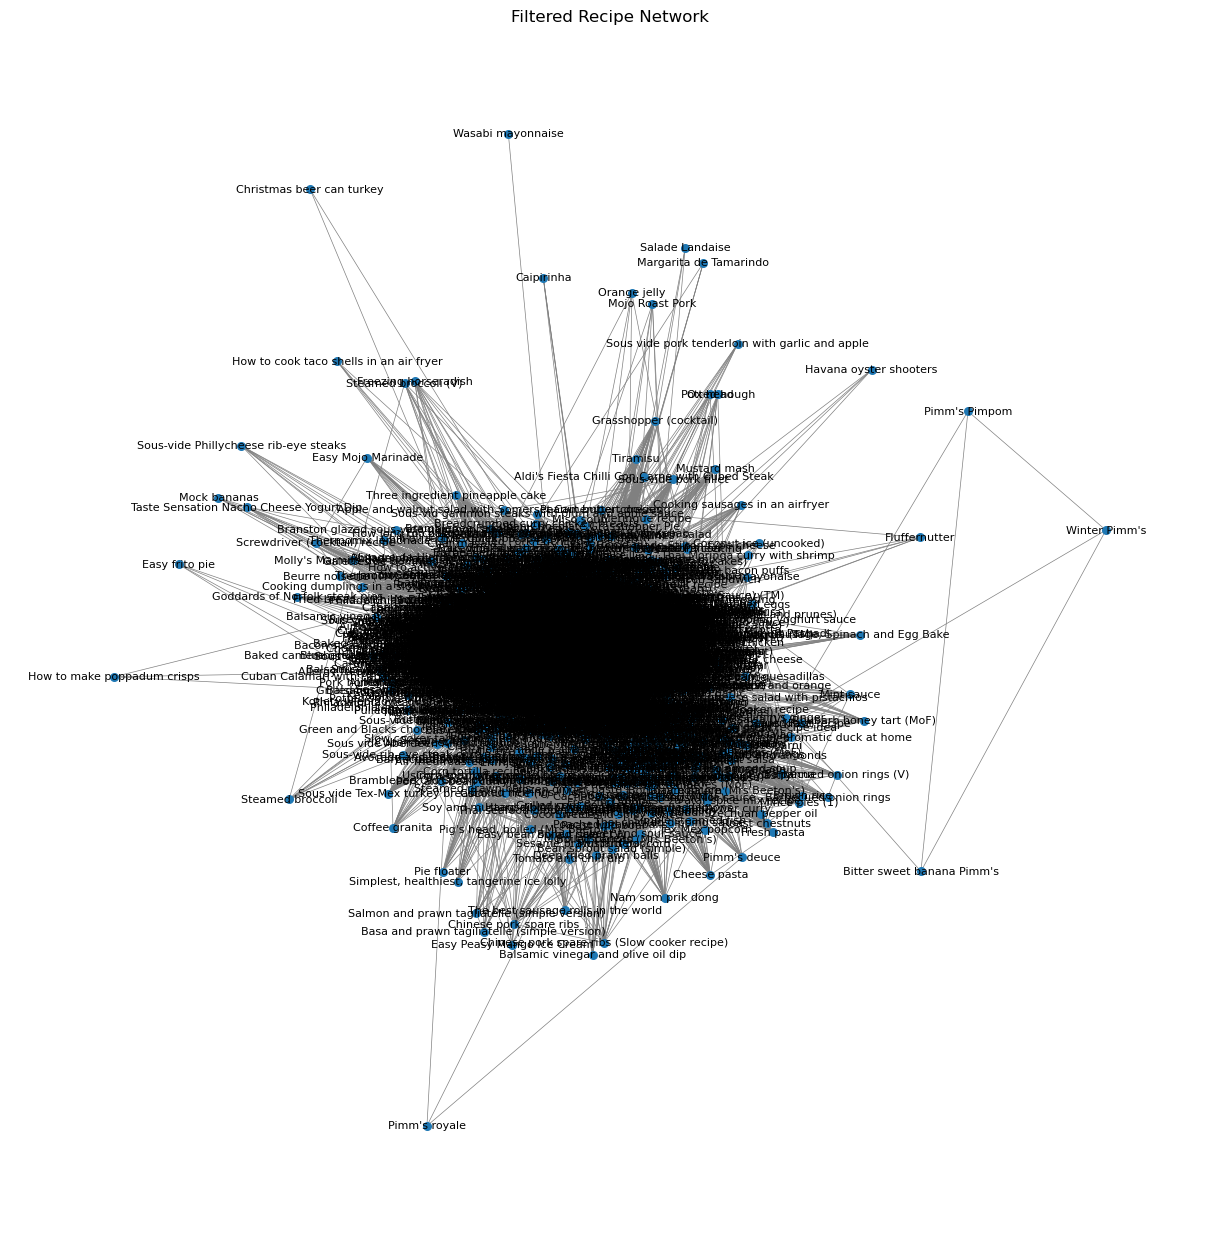

In [16]:
# Different layout and visualization adjustments
pos = nx.spring_layout(G_rec_sub, k=0.15, iterations=20)

plt.figure(figsize=(12, 12))
nx.draw(
    G_rec_sub,
    pos,
    node_size=30,
    font_size=8,
    font_color="black",
    with_labels=True,
    width=0.5,
    edge_color="gray",
)
plt.title("Filtered Recipe Network")
plt.show()

CHECK RECIPES WITH x INGREDIENTS

In [28]:
x = 36
# Use the .loc method to find the element in the "Recipe" column in the row labeled "Recipe 1"


for index, row in recipes_data.iterrows():

    if len(row["ingredients"]) == x:
        recipe_name = row["Recipe"]


        recipe_ingredients = row["ingredients"]


        print(f"Recipe '{recipe_name}' has {x} ingredients: {recipe_ingredients}")

Empty DataFrame
Columns: [Recipe, total_calories, portion_calories, difficulty, servings, total_time, prep_time, cook_time, ingredients]
Index: []
Recipe 'Cuban Sancoche' has 36 ingredients: ['Stewing', 'Beef', 'Chorizo', 'Plantains', 'Cup', 'Lemon juice', 'Cup', 'Yuca', 'Cassava', 'Manioc', 'Cup', 'Sweet potatoes', 'Yam', 'Cup', 'Potatoes', 'Cup', 'Pigeon peas', 'Pumpkin', 'Cilantro', 'Coriander', 'Chinese', 'Parsley', 'Goya\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\u00ae Adobo con Chile Habanero', 'Cumin', 'Onion', 'Garlic', 'Pepper', 'Parsley', 'Onion', 'Cloves of garlic', 'Green pepper', 'Black pepper', 'Olive oil', 'Tomato paste', 'Salt', 'Brown sugar']


In [ ]:
# Function to extract ingredients from a recipe text
def extract_ingredients(recipe_text):
    # Define the pattern to extract ingredients from recipe text
    pattern = r"RecipeIngredients(.*?)Method"
    match = re.search(pattern, recipe_text, re.DOTALL)
    if match:
        # Extract ingredients using regex pattern
        ingredient_pattern = r"\[\[([^\]|]+)\|?[^\]]*\]\]"
        ingredients = re.findall(ingredient_pattern, match.group(1))
        return set(ingredients)
    else:
        return set()


# Function to add edges to the graph based on ingredients and country
def add_edges(graph, recipe, ingredients, country):
    unique_ingredients = set()  # Set so we just have unique values

    for ingredient in ingredients:
        # Check for non-ASCII characters and skip adding those nodes
        if all(ord(char) < 128 for char in ingredient):
            unique_ingredients.add(ingredient)  # Add unique ingredient to the list

    # Creation of weighted edges bewteen the unique ingredients
    for i, ingr1 in enumerate(unique_ingredients):
        for ingr2 in list(unique_ingredients)[
            i + 1 :
        ]:  # No confront between edges already confronted
            if graph.has_edge(ingr1, ingr2):
                graph[ingr1][ingr2][
                    "weight"
                ] += 1  # If edge already exists increment weight
                for u, v, d in graph.edges(data=True):
                    print(f"Arco: {u} - {v}, Peso: {d['weight']}")
            else:
                graph.add_edge(
                    ingr1, ingr2, weight=1
                )  # Otherwise new edge with weight 1

In [ ]:
# Initialize an undirected graph
G_recipes = nx.Graph()

# Directory containing recipe files
recipes_dir = "recipes"

# Read the recipe titles and countries from a CSV file using csv.reader
with open("recipe_titles.csv", "r") as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip the header
    for row in reader:
        country, title = row
        country_dir = os.path.join(recipes_dir, country)

        # Iterate through the files in the directory (handling non-ASCII characters)
        for file in os.listdir(country_dir):
            if title in file:
                recipe_file_path = os.path.join(country_dir, file)

                # Read the recipe file
                with open(recipe_file_path, "r", encoding="utf-8") as recipe_file:
                    recipe_text = recipe_file.read()

                    # Extract ingredients from the recipe text
                    ingredients = extract_ingredients(recipe_text)

                    # Add ingredients to the graph
                    for ingredient in ingredients:
                        # Check for non-ASCII characters and skip adding those nodes
                        if all(ord(char) < 128 for char in ingredient):
                            if not G_recipes.has_node(ingredient):
                                G_recipes.add_node(ingredient)

                            # Add an edge between the ingredient and the recipe
                            add_edges(G_recipes, title, [ingredient], country)

# Filter edges based on edge weight threshold
threshold_weight = 1

filtered_edges = [
    (u, v) for u, v, d in G_recipes.edges(data=True) if d["weight"] > threshold_weight
]
for u, v, d in G_recipes.edges(data=True):
    print(f"Arco: {u} - {v}, Peso: {d['weight']}")
# Create a subgraph containing only filtered edges and their associated nodes
G_rec_sub = G_recipes.edge_subgraph(filtered_edges)

print("Nodes in the subgraph:", G_rec_sub.number_of_nodes())
print("Edges in the subgraph:", G_rec_sub.number_of_edges())

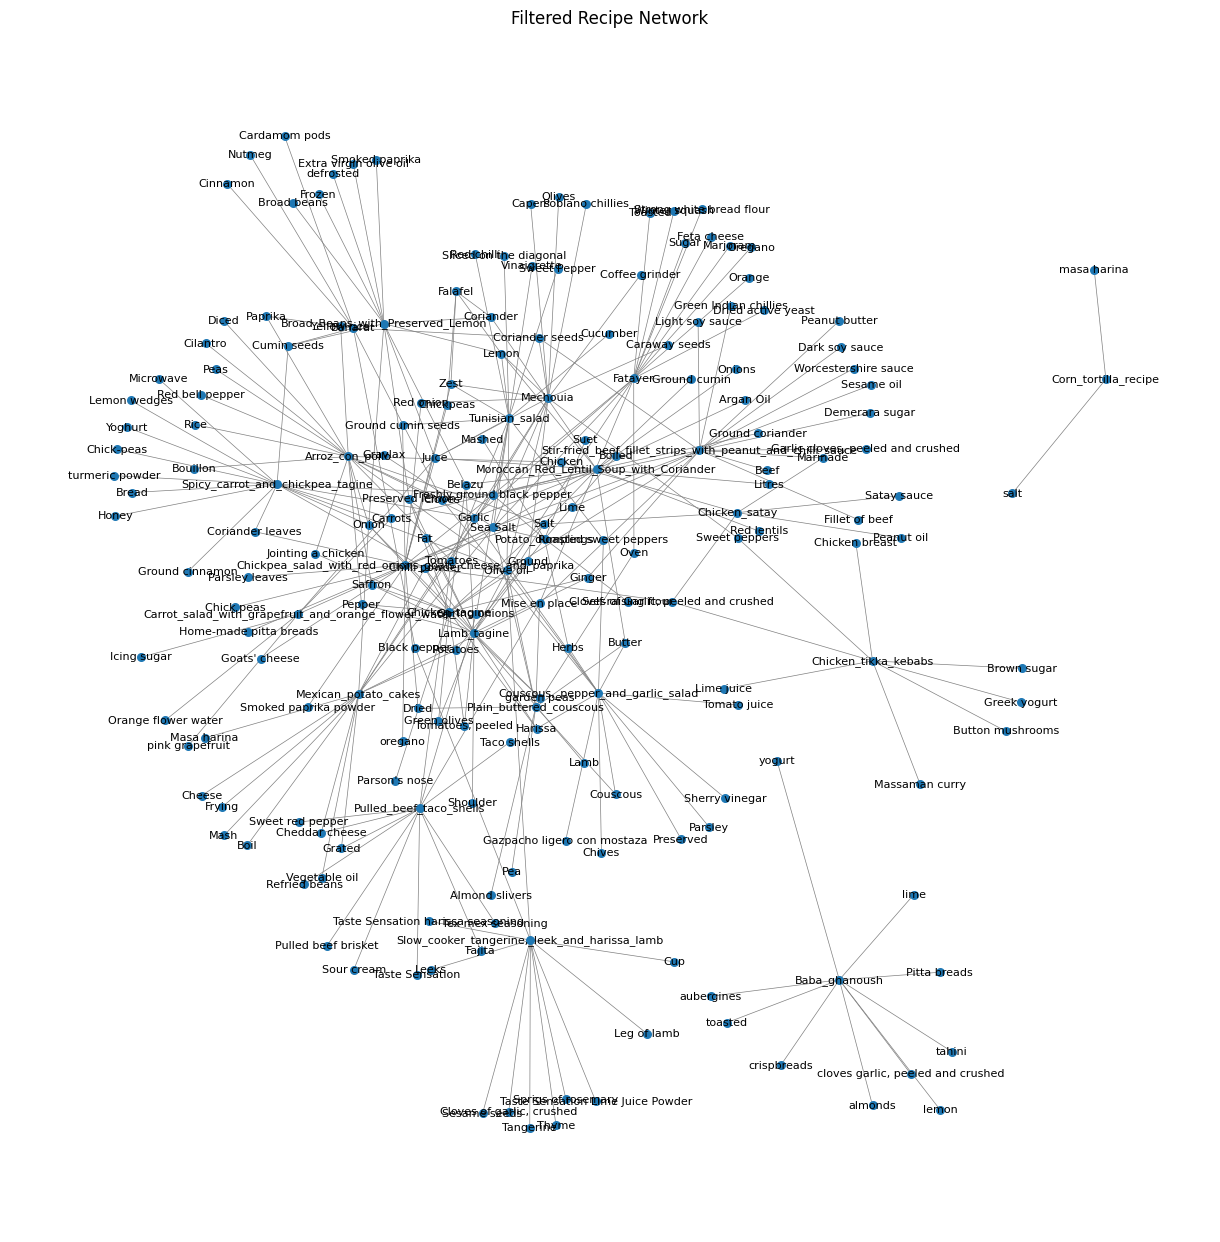

In [6]:
pos = nx.spring_layout(G_rec_sub, k=0.15, iterations=20)

plt.figure(figsize=(12, 12))
nx.draw(
    G_rec_sub,
    pos,
    node_size=30,
    font_size=8,
    font_color="black",
    with_labels=True,
    width=0.5,
    edge_color="gray",
)
plt.title("Filtered Recipe Network")
plt.show()

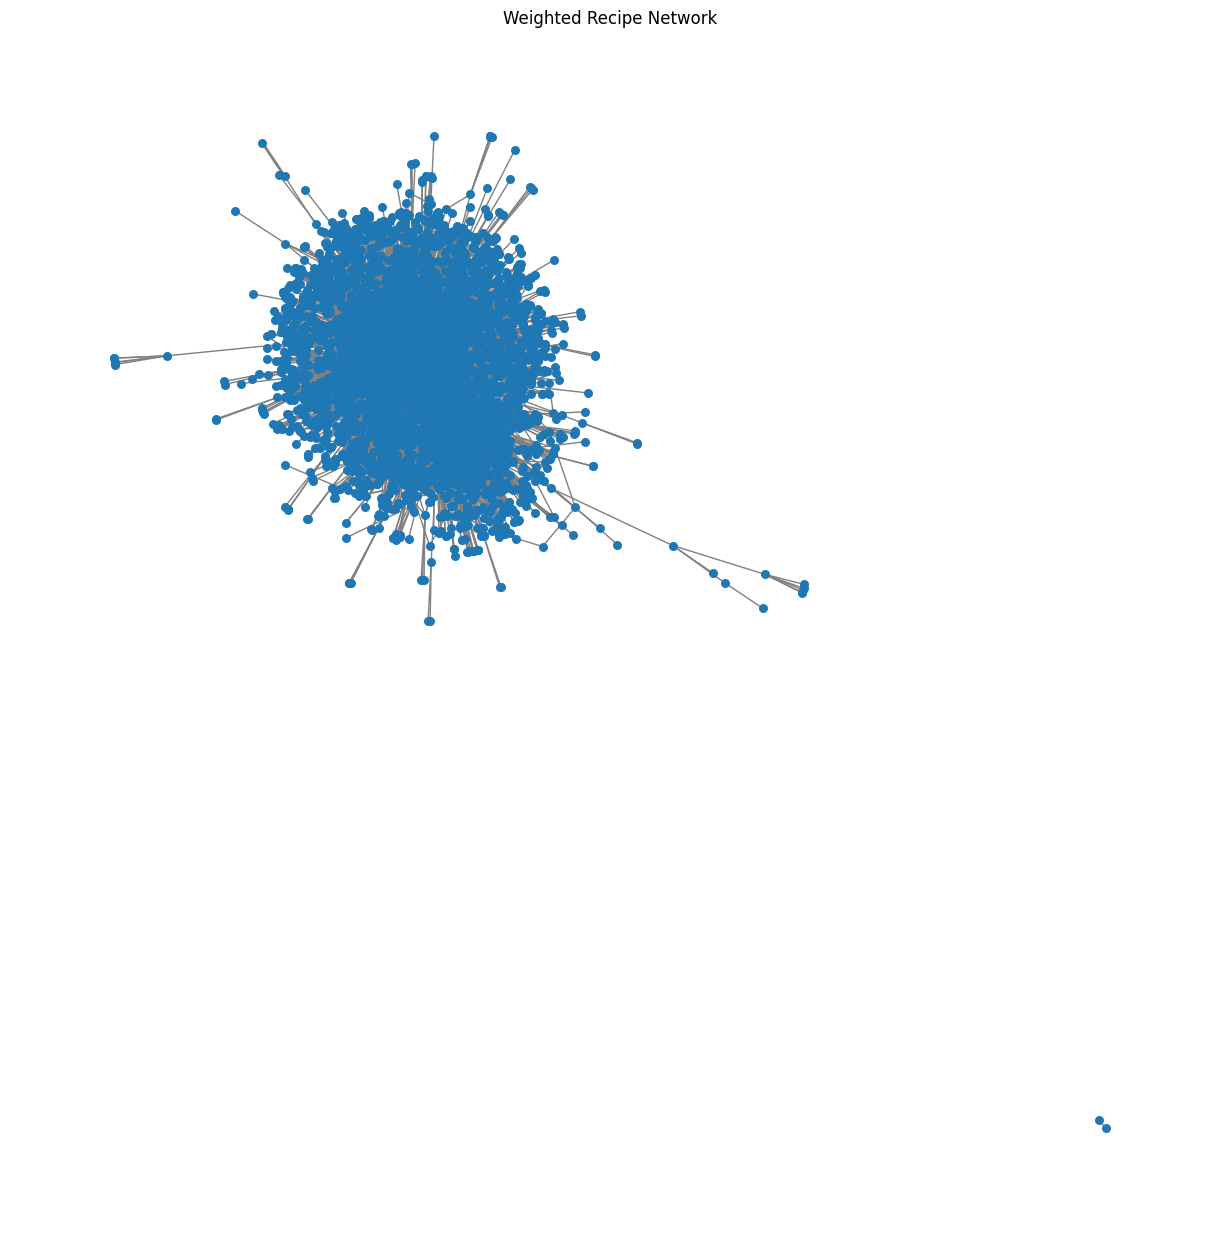

In [2]:
# Function to extract ingredients from a recipe text
def extract_ingredients(recipe_text):
    # Define the pattern to extract ingredients from recipe text
    pattern = r"RecipeIngredients(.*?)Method"
    match = re.search(pattern, recipe_text, re.DOTALL)
    if match:
        # Extract ingredients using regex pattern
        ingredient_pattern = r"\[\[([^\]|]+)\|?[^\]]*\]\]"
        ingredients = re.findall(ingredient_pattern, match.group(1))
        return ingredients  # Return a list of ingredients
    else:
        return []


# Function to add edges to the graph based on ingredients and country
def add_edges(graph, recipe, ingredients, country):
    ingredient_count = {}  # Dictionary to count ingredient occurrences

    for ingredient in ingredients:
        # Check for non-ASCII characters and skip adding those nodes
        if all(ord(char) < 128 for char in ingredient):
            # Count occurrences of each ingredient across different recipes
            if ingredient in ingredient_count:
                ingredient_count[ingredient] += 1
            else:
                ingredient_count[ingredient] = 1

    for ingredient, count in ingredient_count.items():
        if not graph.has_node(ingredient):
            graph.add_node(ingredient)

        # Add an edge between the recipe and the ingredient with weight (based on count)
        graph.add_edge(recipe, ingredient, weight=count)


# Initialize an undirected graph
graph = nx.Graph()

# Directory containing recipe files
recipes_dir = "recipes"

# Read the recipe titles and countries from a CSV file using csv.reader
with open("recipe_titles.csv", "r") as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip the header
    for row in reader:
        country, title = row
        country_dir = os.path.join(recipes_dir, country)

        # Iterate through the files in the directory (handling non-ASCII characters)
        for file in os.listdir(country_dir):
            if title in file:
                recipe_file_path = os.path.join(country_dir, file)

                # Read the recipe file
                with open(recipe_file_path, "r", encoding="utf-8") as recipe_file:
                    recipe_text = recipe_file.read()

                    # Extract ingredients from the recipe text
                    ingredients = extract_ingredients(recipe_text)

                    # Add ingredients to the graph with weighted edges
                    add_edges(graph, title, ingredients, country)

# Plotting the weighted graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(graph)
edge_weights = [graph[u][v]["weight"] for u, v in graph.edges]

nx.draw(
    graph,
    pos,
    node_size=30,
    font_color="black",
    width=edge_weights,  # Use edge weights for varying edge thickness
    edge_color="gray",
)
plt.title("Weighted Recipe Network")
plt.show()

# Community Analysis

## Ingredients Analysis

In [19]:
# Louvain Algorithm
louvain_partition = community_louvain.best_partition(G_ing_sub)
louvain_modularity = community_louvain.modularity(louvain_partition, G_ing_sub)
print(f"Louvain Modularity: {louvain_modularity}")

# Girvan-Newman Algorithm (Edge Betweenness)
communities_generator = nx.algorithms.community.girvan_newman(G_ing_sub)
top_level_communities = next(communities_generator)
girvan_newman_modularity = nx.algorithms.community.quality.modularity(
    G_ing_sub, top_level_communities
)
print(f"Girvan-Newman Modularity: {girvan_newman_modularity}")

# Label Propagation
label_propagation_communities = list(
    nx.algorithms.community.label_propagation.label_propagation_communities(G_ing_sub)
)
label_propagation_modularity = nx.algorithms.community.quality.modularity(
    G_ing_sub, label_propagation_communities
)
print(f"Label Propagation Modularity: {label_propagation_modularity}")

Louvain Modularity: 0.2378992885707619
Girvan-Newman Modularity: 0.00011974741886673157
Label Propagation Modularity: 0.0002394711616554189


In [20]:
num_communities = len(set(louvain_partition.values()))
print(f"Number of communities: {num_communities}")
print(f"Modularity: {louvain_modularity}")

Number of communities: 10
Modularity: 0.2378992885707619


Community 0: 737 nodes
Community 1: 539 nodes
Community 2: 622 nodes
Community 3: 780 nodes
Community 4: 90 nodes
Community 5: 46 nodes
Community 6: 7 nodes
Community 7: 17 nodes
Community 8: 7 nodes
Community 9: 3 nodes


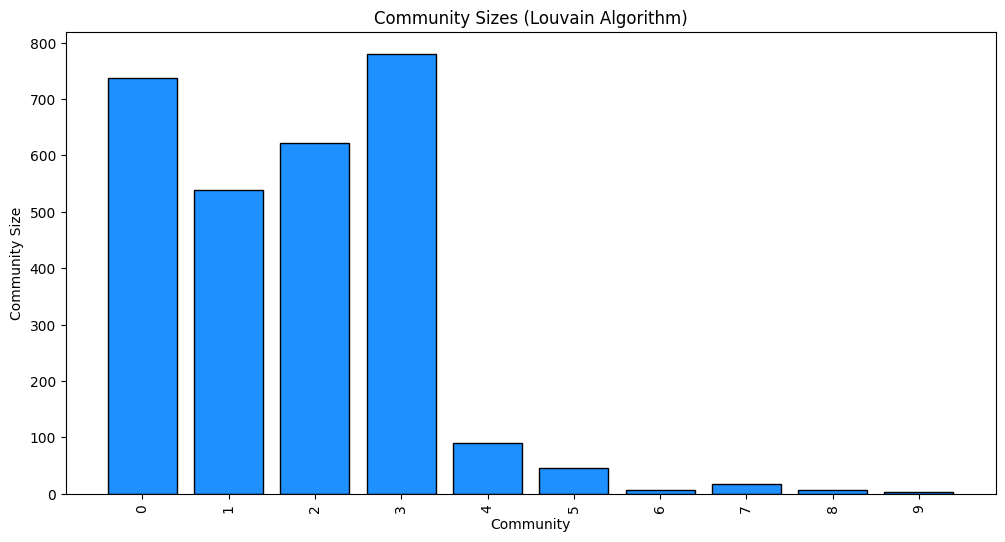

In [21]:
# Create a dictionary to count the sizes of each community
community_sizes = {}
for node, community_id in louvain_partition.items():
    if community_id in community_sizes:
        community_sizes[community_id] += 1
    else:
        community_sizes[community_id] = 1

# Community sizes
for community_id in sorted(community_sizes.keys()):
    size = community_sizes[community_id]
    print(f"Community {community_id}: {size} nodes")

community_sizes_values = list(community_sizes.values())
community_sizes_labels = list(community_sizes.keys())

plt.figure(figsize=(12, 6))
plt.bar(
    community_sizes_labels,
    community_sizes_values,
    color="dodgerblue",
    edgecolor="black",
)
plt.title("Community Sizes (Louvain Algorithm)")
plt.xlabel("Community")
plt.ylabel("Community Size")
plt.xticks(community_sizes_labels, rotation="vertical")
plt.show()

Modularity: 0.24219027808811924


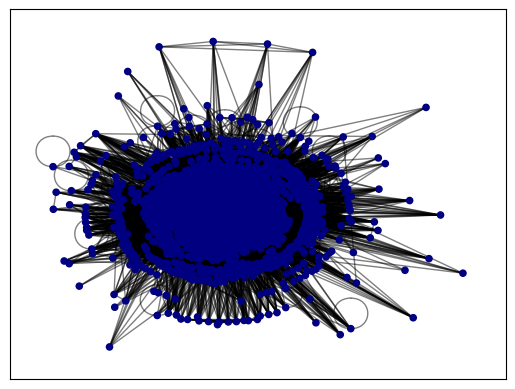

In [22]:
from networkx.algorithms.community.quality import modularity

partition = nx.community.louvain_communities(G_ing_sub)

# Compute the Louvain communities within the 'east' subgraph
communities = list(nx.community.louvain_communities(G_ing_sub))

# Ensure there are multiple communities
if len(communities) > 1:
    # Calculate the modularity for the partition using nx.community.modularity
    mod = modularity(G_ing_sub, communities)

    # Print the modularity value
    print(f"Modularity: {mod}")

    # Use the Kamada-Kawai layout for better node positioning
    pos = nx.kamada_kawai_layout(G_ing_sub)

    # Drawing with community-based colors
    size = float(len(communities))
    count = 0.0
    for com in communities:
        count += 1.0
        list_nodes = [node for node in com]

        # Draw nodes with positions
        nx.draw_networkx_nodes(
            G_ing_sub,
            pos,
            nodelist=list_nodes,
            node_size=20,
            cmap=plt.get_cmap("jet", len(communities)),
            node_color=[count / size] * len(list_nodes),
        )

    nx.draw_networkx_edges(G_ing_sub, pos, alpha=0.5)

    plt.show()
else:
    print("No valid communities found.")

## Recipes Analysis

In [5]:
from networkx.algorithms import community

# Group nodes into communities based on the "Country" attribute
country_communities = {}
for node, data in G_recipes.nodes(data=True):
    country = data.get("Country")
    if country not in country_communities:
        country_communities[country] = [node]
    else:
        country_communities[country].append(node)

# Create a subgraph for each country community
subgraphs = {}
for country, nodes in country_communities.items():
    subgraph = G_recipes.subgraph(nodes)
    subgraphs[country] = subgraph

modularity_values = {}

for country, subgraph in subgraphs.items():
    # Calculate modularity only if the subgraph has nodes and edges
    if subgraph.number_of_nodes() > 0 and subgraph.number_of_edges() > 0:
        communities_generator = list(community.greedy_modularity_communities(subgraph))
        modularity = community.modularity(subgraph, communities_generator)
        modularity_values[country] = modularity
        print(f"Number of nodes {subgraph.number_of_nodes()} in {country} community")
    else:
        print(f"Empty subgraph for country: {country}")

# Print modularity values for each non-empty country community
for country, modularity in modularity_values.items():
    print(f"Country: {country} - Modularity: {modularity}")

Number of nodes 2487 in None community
Country: None - Modularity: 0.000412957426523009


In [6]:
# Louvain Algorithm
louvain_partition = community_louvain.best_partition(G_rec_sub)
louvain_modularity = community_louvain.modularity(louvain_partition, G_rec_sub)
print(f"Louvain Modularity: {louvain_modularity}")

# Girvan-Newman Algorithm (Edge Betweenness)
communities_generator = nx.algorithms.community.girvan_newman(G_rec_sub)
top_level_communities = next(communities_generator)
girvan_newman_modularity = nx.algorithms.community.quality.modularity(
    G_rec_sub, top_level_communities
)
print(f"Girvan-Newman Modularity: {girvan_newman_modularity}")

# Label Propagation
label_propagation_communities = list(
    nx.algorithms.community.label_propagation.label_propagation_communities(G_rec_sub)
)

label_propagation_modularity = nx.algorithms.community.quality.modularity(
    G_rec_sub, label_propagation_communities
)
print(f"Label Propagation Modularity: {label_propagation_modularity}")

Louvain Modularity: 0.00890585394781176
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Dell\AppData\Local\Temp\ipykernel_20828\832496744.py", line 8, in <module>
    top_level_communities = next(communities_generator)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\networkx\algorithms\community\centrality.py", line 147, in girvan_newman
    yield _without_most_central_edges(g, most_valuable_edge)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\networkx\algorit